# Control experiments: alternation vs. change

In [1]:
# imports and functions
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
import pandas as pd
import scipy.io as sio
#from scipy.signal import savgol_filter
from scipy.signal import butter, lfilter
#from sklearn import mixture#
from glob import glob as glob
import os
import scipy.io as io
from scipy.ndimage import gaussian_filter1d
from skimage.measure import label
import seaborn as sb
import h5py
from scipy.signal import gaussian
from scipy.ndimage import filters
from sklearn.metrics import roc_auc_score
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["font.size"]= 12
plt.rcParams["font.family"] = "Arial"

In [2]:
# parameters
in_path = '/Volumes/Bellet/PhD/Local_Global/A11_AvsC/'
dates = os.listdir(in_path)
dates = [dates[i] for i in range(len(dates)) if dates[i][0]=='2'] # filter
out_path = '/Volumes/Bellet/PhD/Local_Global/A11_AvsC/processed_data/'

folders = np.sort([os.path.join(in_path,'%s'%date) for date in dates])

## Functions

In [61]:
def get_stim_log(path,start_trial):
    log_file = sio.loadmat(path)
    Stim_times = log_file['Log'][0,0]['Trial']['Stim_times'][0]
    Stim_IDs = log_file['Log'][0,0]['Trial']['Stim_IDs'][0]
    Reward = log_file['Log'][0,0]['Trial']['Reward_time'][0]
    Onsets = []
    IDs = []
    Trial_count = []
    Rewardtimes = []
    for i in range(len(Stim_times)):
        trial = i+start_trial
        #if len(Reward[i])>0:
        for j in range(len(Stim_times[i][0])):
            Onsets.append(Stim_times[i][0][j])
            IDs.append(Stim_IDs[i][0][j][0])
            Trial_count.append(trial)
            if (j==3) & (len(Reward[i])>0):
                Rewardtimes.append(Reward[i][0,0] - Stim_times[i][0][-1])
            else:
                Rewardtimes.append(-1)
#
    df = pd.DataFrame({'Onsets': Onsets,
                      'IDs':IDs,
                      'Trial_count':Trial_count,
                      'Reward_times':Rewardtimes})
    
    return(df,log_file)




# spike alignment functions
def getSpikes(folder):
    SpikeTimes = []
    
    # import spike stimes from Fanis' spike extraction method
    import h5py
    f = h5py.File(os.path.join(folder,'PFCSpikes.mat'))
    spikes = f['spikesPFC']
    nch = spikes.shape[0] # number of channels
    for ch in range(nch):
        sp = f[spikes[ch,0]]['times'][:,0]
        w = f[spikes[ch,0]]['waveforms']
        SpikeTimes.append(sp[w[14,:]<0]) # time at 30 kHz

    return(SpikeTimes)

def rate_binning(spike_times,time_bins,binsize):
    average = np.zeros((len(spike_times),len(time_bins)))
    for i,t in enumerate(time_bins):
        
        for chan in range(len(spike_times)):
            include = (spike_times[chan]>=t) & (spike_times[chan]<(t+binsize))
            average[chan,i] = sum(include)/binsize
    return average

def smoothing(signal,sd,binsize):
    ''' aplly gaussian filter per trial'''
    kernel = gaussian(signal.shape[-1],sd/binsize)
    ga = np.zeros(signal.shape)
    if len(signal.shape)>3:
        for dim1 in range(signal.shape[0]):
            for dim2 in range(signal.shape[1]):
                for dim3 in range(signal.shape[2]):
                    ga[dim1,dim2,dim3,:] = filters.convolve1d(signal[dim1,dim2,dim3,:], kernel/kernel.sum())
    else:
        for dim1 in range(signal.shape[0]):
            ga[dim1,:] = filters.convolve1d(signal[dim1,:], kernel/kernel.sum())
                
    return ga

def clustertest(true,permutations,thresh):
    nperm = permutations.shape[-1]
    t_val = abs((true - np.mean(permutations,-1)) / np.std(permutations,-1)) # 2-sided
    above_threshold = t_val>thresh
    sig_clust = label(above_threshold)
    clust_sum = np.zeros(np.max(sig_clust))
    for c in range(1,max(sig_clust)+1):
        
        clust_sum[c-1] = np.sum(t_val[sig_clust==c])
    # get random clusters
    clust_sum_rand = np.zeros(nperm)
    for perm in range(nperm):
        compare_to = np.delete(permutations,perm,axis=-1)
        t_val = abs((permutations[:,perm] - np.mean(compare_to,-1)) / np.std(compare_to,-1))
        above_threshold = t_val>thresh
        sig_clust_rand = label(above_threshold)
        if np.max(sig_clust_rand)>0:
            clust_sum_r = np.zeros(np.max(sig_clust_rand))
            for c in range(1,max(sig_clust_rand)+1):
                clust_sum_r[c-1] = np.sum(t_val[sig_clust_rand==c])
            clust_sum_rand[perm] = np.max(clust_sum_r)
    # compard random and true
    P = np.zeros(true.shape)*np.nan
    for c in range(len(clust_sum)):
        P[sig_clust==c+1] = np.mean(clust_sum[c]<=clust_sum_rand)
    return P

20201124


/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000

MATCHING number of photodiode pulses and stimuli according to log files
20201125


/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000gn/T/ipykernel_18326/3744053958.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df)
/var/folders/pl/p71mm7_d2yz6chp4jvthndcm0000

MATCHING number of photodiode pulses and stimuli according to log files


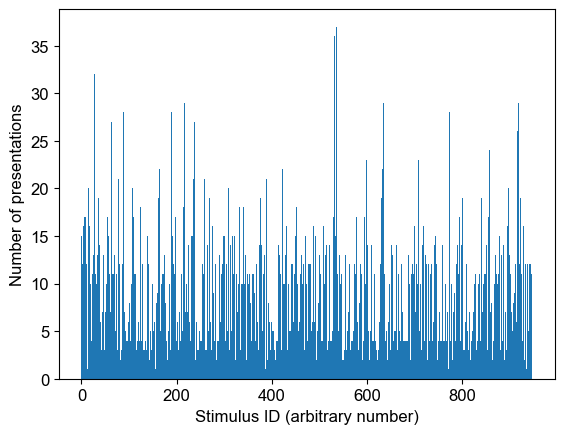

Number of presented stimuli: 8895
Fraction of alternations: 0.5942664418212479
SOAs: [0.4 0.5 0.6]


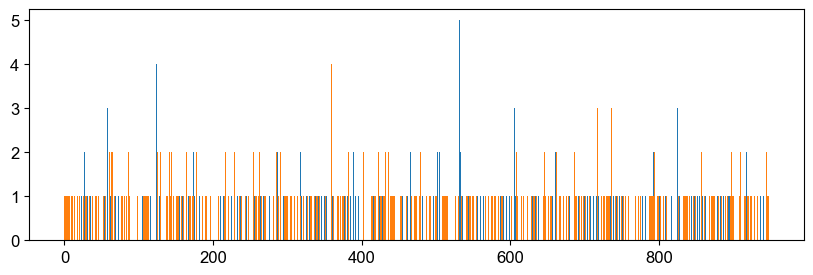

Stimuli with at least one repetition and one repeat: 453/948


In [66]:
photo_channel = 3
photo_fs = 2000

# get log files
dfs = pd.DataFrame()
dates = []
photo_onset_times = []
for i,folder in enumerate(folders):
    date = folder[-8:]
    print(date)
    all_log_path = np.sort(glob(os.path.join(in_path, folder,'Log_StimSettings*')))
    log_files = []
    n_stim = 0
    start_trial = 0
    for f in all_log_path:
        df,_ = get_stim_log(f,start_trial)
        if len(df)>0:
            start_trial = np.max(df.Trial_count)
            dates.extend(np.repeat(date,len(df)))
            dfs = dfs.append(df) 
            n_stim += len(df)
    
        
    # photodiode
    with h5py.File(os.path.join(in_path,folder,'analogData.mat'), 'r') as f:
        ref = f['analog']['data'][photo_channel][0] # only extract photodiode signal here
        photo = np.array(f[ref][0,:])
    
    # detect events:
    photo_thresh = (photo>(8*np.median(photo)/0.6745)).astype(float)
    photo_onsets = np.where(np.diff(photo_thresh)==1)[0]+1

    if len(photo_onsets)==n_stim:
        print('MATCHING number of photodiode pulses and stimuli according to log files')
        # get time of photodiode signal
        photo_onset_times.extend(photo_onsets/photo_fs)
        
    else:
        print('MISMATCH between analog signal and log files')
        print(len(photo_onsets),n_stim)
photo_onset_times = np.array(photo_onset_times)
    
# assign number to each stimulus ID
unique_IDs = np.unique(dfs.IDs)
n_unique = len(unique_IDs)
n_stim = len(dfs)
stim_ID = np.zeros(n_stim)
for i,ID in enumerate(unique_IDs):
    stim_ID[dfs.IDs==ID] = i
        
# plot how many times each stim was shown
plt.hist(stim_ID,bins=n_unique)
plt.xlabel('Stimulus ID (arbitrary number)')
plt.ylabel('Number of presentations')
plt.show()
    
# create variable indicating repeats / alternation (1= alternation, 0 = repeat)
alt = np.concatenate((np.zeros(1),(np.diff(stim_ID)==0).astype(int)))
alt = (alt==0).astype(int)
print('Number of presented stimuli:',len(dfs))
print('Fraction of alternations:',np.mean(alt==1))
    
# get variables
# first get item number

itemID = np.zeros(n_stim)
trials = np.unique(dfs.Trial_count)
item_count = 1 # initialize
for i in range(n_stim):
    if i>0:    
        trial_num = dfs.Trial_count.iloc[i]
        if trial_num==dfs.Trial_count.iloc[i-1]:
            itemID[i] = item_count
            item_count += 1
        else:
            itemID[i] = 0
            item_count = 1
 
# get soa per stimulus
stim_soa = np.concatenate((np.zeros(1),np.diff(photo_onset_times)))
all_soa = np.unique(np.round(stim_soa[itemID==3],1)) # get soa of last item and round
print('SOAs:',all_soa)

# check stimuli that occur at least once as alternation and as repetition
which_item = 2
rep_count = np.zeros(n_unique)
alt_count = np.zeros(n_unique)
for stim in range(n_unique):
    rep_count[stim] = sum((stim_ID[itemID==which_item]==stim) & (alt[itemID==which_item]==1))
    alt_count[stim] = sum((stim_ID[itemID==which_item]==stim) & (alt[itemID==which_item]==0))
    
width = .4
plt.figure(figsize=(10,3))
plt.bar(np.arange(n_unique),rep_count)
plt.bar(np.arange(n_unique)+width,rep_count)
plt.show()


# define trial types based on last item
last_item = itemID==3
trial_type =  np.zeros(sum(last_item))
for i,ind in enumerate(np.where(last_item)[0]):
    n_repeats = sum(alt[ind-2:ind+1]==0)
    trial_type[i] = n_repeats
print('Stimuli with at least one repetition and one repeat: %s/%s'%(sum(rep_count*alt_count>0), n_unique))

## Spiking activity

In [5]:
# get spikes
tmin = -0.1
tmax = .6
binsize = 0.05
step = 0.01
sd = 0.05 # standard deviation of gaussian kernel
time_bins = np.arange(tmin,tmax-binsize,step)

nbins = len(time_bins)
sf = 30000
nch = 96

MUAall = np.load(os.path.join(out_path,'RvsA_MUAall.npy'))

or recompute:

In [5]:

MUA = []
for j,folder in enumerate(folders):
    SpikeTimes = getSpikes(os.path.join(in_path,folder))
    # photo times of session
    is_date = [d==folder[-8:] for d in dates]
    photo_onsets = photo_onset_times[is_date] 
    print(len(photo_onsets))
    # align spikes
    Spikes = []
    for ch in range(len(SpikeTimes)):
        #Spikes.append([])
        spikes = SpikeTimes[ch] # spikes from channel
        spikes /= sf # convert to s
        for s,ph in enumerate(photo_onsets): #align to every stimulus
            sp = spikes[((spikes-ph)>=tmin) & ((spikes-ph)<tmax)] - ph
            if ch==0:
                Spikes.append([])
            Spikes[s].append(sp)
    
    # PSTH
    #len(SpikeTimes)
    MUA.append(np.zeros((len(Spikes),nch,nbins)))
    for i in range(len(Spikes)):
        sp = rate_binning(Spikes[i],time_bins,binsize)
        #smooth
        #sp = smoothing(sp,sd,binsize)[:,int(4*sd/binsize):-int(4*sd/binsize)] # cut borders: 4*sd
        MUA[j][i,:] = sp


MUAall= []
for f in range(len(MUA)):
    MUAall.extend(MUA[f])
MUAall = np.array(MUAall)
print(MUAall.shape)

np.save(os.path.join(out_path,'RvsA_MUAall.npy'),MUAall)

# Logistic regression models

In [6]:
# first, centre each channel
MUAc = MUAall.copy() 
for ch in range(nch):
    MUAc[:,ch,:] = (MUAc[:,ch,:] - np.mean(MUAc[:,ch,:])) / (np.std(MUAc[:,ch,:]) + 10e-6)

# Deviance decoder
For training, use only last item and contrast aaaB vs. bbbb.

Using soa = .6 only

In [53]:
from sklearn.linear_model import LogisticRegression
soa = .6
which_item = 3
trials = (itemID==which_item) & (np.round(stim_soa,1)==soa) # select trials for training


unique_in_training_item = np.unique(stim_ID[trials]) # get unique stim IDs in selected sequence position
n_unique = len(unique_in_training_item)
print('Number of unique stim in position %s with SOA=%s: %s'%(which_item+1,soa,n_unique))
K = n_unique # leave-one-stim-out CV

trial_type_soa = trial_type[np.round(stim_soa[itemID==3],1)==soa] # trial type variable is only for last item. So to select only certain soa, subsample this variable
nbins = len(time_bins)

# get stimulus identities that don't occur in position 4:
# this is for leave-one-stimulus-out cross validation
not_included = np.zeros(n_stim)
for s in range(n_stim):
    stim = stim_ID[s]
    if int(stim) not in unique_in_training_item:
        not_included[s] = 1
not_included = not_included.astype(int)

# pre-allocation:
Prob = np.zeros((n_stim,nbins))
Coef = np.zeros((K,nch,nbins))
for k,stim in enumerate(unique_in_training_item):
    print('Stimulus %s/%s'%(k+1,n_unique))
    training_ind = np.where(stim_ID[trials]!=stim)[0]
    test_ind = stim_ID==stim
    
    # balance training data    
    n = np.min([sum(trial_type_soa[training_ind]==2),sum(trial_type_soa[training_ind]==3)])
    ind = []
    for t in [2,3]:
        cond_ind = np.where(trial_type_soa[training_ind]==t)[0]
        ind.extend(cond_ind[np.random.permutation(len(cond_ind))][:n])
    training_ind = training_ind[ind]
    MUA_train = MUAc[trials,:][training_ind,:]
    y_train = alt[trials][training_ind]

    #print('N training trials:',len(y_train))
    #print('Ration of aaaB/bbbB trials in training data:',np.mean(y_train))
    for b in range(nbins):
        model = LogisticRegression(fit_intercept=False,solver='lbfgs').fit(MUA_train[:,:,b],y_train)
        # get predictive probability for test stimulus, all positions
        Prob[test_ind,b] = model.predict_proba(MUAc[test_ind,:][:,:,b])[:,1]
        Coef[k,:,b] = model.coef_
        if k==0: # only once for stim that are never in training data:
            Prob[not_included==1,b] = model.predict_proba(MUAc[not_included==1,:][:,:,b])[:,1]
            

Number of unique stim in position 4 with SOA=0.6: 757
Stimulus 1/757
Stimulus 2/757
Stimulus 3/757
Stimulus 4/757
Stimulus 5/757
Stimulus 6/757
Stimulus 7/757
Stimulus 8/757
Stimulus 9/757
Stimulus 10/757
Stimulus 11/757
Stimulus 12/757
Stimulus 13/757
Stimulus 14/757
Stimulus 15/757
Stimulus 16/757
Stimulus 17/757
Stimulus 18/757
Stimulus 19/757
Stimulus 20/757
Stimulus 21/757
Stimulus 22/757
Stimulus 23/757
Stimulus 24/757
Stimulus 25/757
Stimulus 26/757
Stimulus 27/757
Stimulus 28/757
Stimulus 29/757
Stimulus 30/757
Stimulus 31/757
Stimulus 32/757
Stimulus 33/757
Stimulus 34/757
Stimulus 35/757
Stimulus 36/757
Stimulus 37/757
Stimulus 38/757
Stimulus 39/757
Stimulus 40/757
Stimulus 41/757
Stimulus 42/757
Stimulus 43/757
Stimulus 44/757
Stimulus 45/757
Stimulus 46/757
Stimulus 47/757
Stimulus 48/757
Stimulus 49/757
Stimulus 50/757
Stimulus 51/757
Stimulus 52/757
Stimulus 53/757
Stimulus 54/757
Stimulus 55/757
Stimulus 56/757
Stimulus 57/757
Stimulus 58/757
Stimulus 59/757
Stimulus 60

Stimulus 487/757
Stimulus 488/757
Stimulus 489/757
Stimulus 490/757
Stimulus 491/757
Stimulus 492/757
Stimulus 493/757
Stimulus 494/757
Stimulus 495/757
Stimulus 496/757
Stimulus 497/757
Stimulus 498/757
Stimulus 499/757
Stimulus 500/757
Stimulus 501/757
Stimulus 502/757
Stimulus 503/757
Stimulus 504/757
Stimulus 505/757
Stimulus 506/757
Stimulus 507/757
Stimulus 508/757
Stimulus 509/757
Stimulus 510/757
Stimulus 511/757
Stimulus 512/757
Stimulus 513/757
Stimulus 514/757
Stimulus 515/757
Stimulus 516/757
Stimulus 517/757
Stimulus 518/757
Stimulus 519/757
Stimulus 520/757
Stimulus 521/757
Stimulus 522/757
Stimulus 523/757
Stimulus 524/757
Stimulus 525/757
Stimulus 526/757
Stimulus 527/757
Stimulus 528/757
Stimulus 529/757
Stimulus 530/757
Stimulus 531/757
Stimulus 532/757
Stimulus 533/757
Stimulus 534/757
Stimulus 535/757
Stimulus 536/757
Stimulus 537/757
Stimulus 538/757
Stimulus 539/757
Stimulus 540/757
Stimulus 541/757
Stimulus 542/757
Stimulus 543/757
Stimulus 544/757
Stimulus 545/7

In [126]:
np.save(os.path.join(out_path,'RvsA_Probdev.npy'),Prob)
np.save(os.path.join(out_path,'RvsA_Coefdev.npy'),Coef)

AUC

In [112]:
# AUC
nperm = 100
# trial types to be tested: 0 or 2 against 3
test_trial_types = [0,2]
AUCdev = np.zeros((3,nbins))
RandAUCdev = np.zeros((3,nbins,nperm))
#
# ABCD and cccD trials
for tt,tr in enumerate(test_trial_types):
    ind = np.where(((trial_type==tr) | (trial_type==3)) & (np.round(stim_soa[itemID==3],2)==.6))[0]
    y = alt[itemID==3][ind]
    x = Prob[itemID==3,:][ind,:]
    for b in range(nbins):
        AUCdev[tt,b] = roc_auc_score(y,x[:,b])
    # permutations
    for perm in range(nperm):
        randind = np.random.permutation(len(ind))
        for b in range(nbins):
            RandAUCdev[tt,b,perm] = roc_auc_score(y[randind],x[:,b])
        
# position 2 or 3 aa vs aB or abb vs. abc
trials = (((itemID[1:]==1)) | ((itemID[1:]==2) & (alt[:-1]==1))) & (np.round(stim_soa[1:],1)==soa) # select trials for training
trials = np.where(np.concatenate((np.zeros(1).astype(bool),trials))==1)[0]
y = alt[trials]
x = Prob[trials,:]
for b in range(nbins):
    AUCdev[-1,b] = roc_auc_score(y,x[:,b])
    # permutations
    for perm in range(nperm):
        randind = np.random.permutation(len(trials))
        for b in range(nbins):
            RandAUCdev[-1,b,perm] = roc_auc_score(y[randind],x[:,b])


# AUC for deviance vs alternation along this axis
AUCdev_vs_alt = np.zeros(nbins)
RandAUCdev_vs_alt = np.zeros((nbins,nperm))
trials = np.where(((trial_type==0) | (trial_type==2)) & (np.round(stim_soa[itemID==3],2)==.6))[0]
y = trial_type[trials]; y[y>0] = 1
x = Prob[itemID==3,:][trials,:]
for b in range(nbins):
    AUCdev_vs_alt[b] = roc_auc_score(y,x[:,b])
#    # permutations
    for perm in range(nperm):
        randind = np.random.permutation(len(trials))
        for b in range(nbins):
            RandAUCdev_vs_alt[b,perm] = roc_auc_score(y[randind],x[:,b])

np.save(os.path.join(out_path,'RvsA_AUCdev.npy'),AUCdev)
np.save(os.path.join(out_path,'RvsA_RandAUCdev.npy'),RandAUCdev)
np.save(os.path.join(out_path,'RvsA_AUCdev_vs_alt.npy'),AUCdev_vs_alt)
np.save(os.path.join(out_path,'RvsA_RandAUCdev_vs_alt.npy'),RandAUCdev_vs_alt)

0.0
0.0
0.0


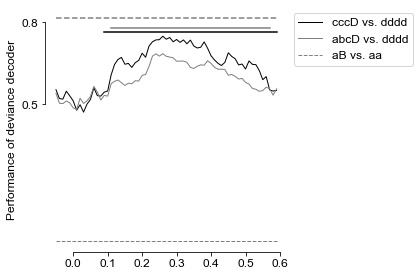

0.0
0.0


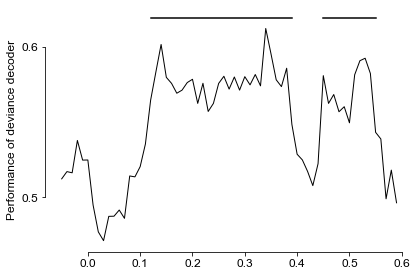

In [134]:
# clustertest
threshold = 1.96
alpha = 0.01

labels = ['abcD vs. dddd','cccD vs. dddd','aB vs. aa']
names = ['Deviant','Alternation_last','Alternation_second','Dev_vs_Alt']
stats = pd.DataFrame(columns=names) # store stats here

# plot
plt.figure()

#plt.ylim(.45,None)
#plt.xticks(np.arange())
plt.yticks((.5,.8))
plt.ylabel('Performance of deviance decoder')

# clustertest
cols = ['k',[.5,.5,.5],[.5,.5,.5]]
linestyles = ['-','-','--']
for ii,tt in enumerate([1,0,2]):
    plt.plot(time_bins+binsize,AUCdev[tt,:],color=cols[ii],linewidth=1,label=labels[tt],linestyle=linestyles[ii])
    
    p = clustertest(AUCdev[tt,:],RandAUCdev[tt,:],threshold)

    l = label(~np.isnan(p))
    ymin,ymax = plt.ylim()
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            print(p[l==j][0])
            plt.plot(time_bins[l==j]+binsize,np.ones(sum(l==j))*ymax,color=cols[ii],
                     linestyle=linestyles[ii],linewidth=1.5)
   
    stats[names[ii]] = [p]
    
plt.legend(bbox_to_anchor=(1,1))
plt.yticks((.5,.8))
sb.despine(trim=True)
plt.tight_layout()
plt.savefig(os.path.join(out_path,'RvsA_Dev_AUC.pdf'),bbox_inches='tight')
plt.show()


# -------- PLOT DEV vs. ALT last position

plt.figure()

#plt.ylim(.45,.8)
#plt.xticks(np.arange())
plt.yticks((.5,.6))
plt.ylabel('Performance of deviance decoder')

# clustertest
plt.plot(time_bins+binsize,AUCdev_vs_alt,color='k',linewidth=1)

p = clustertest(AUCdev_vs_alt,RandAUCdev_vs_alt,threshold)

l = label(~np.isnan(p))
ymin,ymax = plt.ylim()
for j in np.unique(l):
    if p[l==j][0]<=alpha:
        print(p[l==j][0])
        plt.plot(time_bins[l==j]+binsize,np.ones(sum(l==j))*ymax,color='k',
                 linewidth=1.5)

stats[names[-1]] = [p]
sb.despine(trim=True)
plt.tight_layout()
plt.savefig(os.path.join('plots','RvsA_Dev_vs_Alt_AUC.pdf'),bbox_inches='tight')
plt.show()

# Visualization of trajectories from deviance decoder (aaaa vs. aaaB)

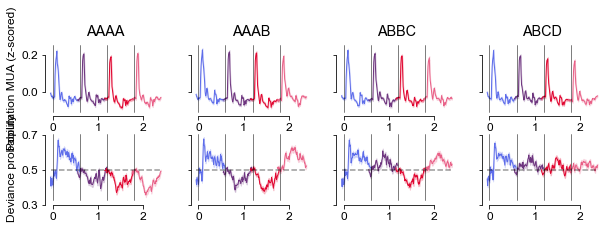

In [125]:
tpre = .1
tpost = .6

fig,ax = plt.subplots(2,4,figsize=(10,3),sharey='row')
colors = np.array([[0.3686602 , 0.43006243, 0.88216096, 0.91511829],
       [0.42644849, 0.20792356, 0.02774958, 0.37733945],
       [0.91794497, 0.49612641, 0.19029442, 0.52845329]])

# AAAA trials
ind = np.where((itemID[3:]==3) & (alt[3:]==0) & (alt[:-3] ==1) & (alt[2:-1] ==0) & (alt[1:-2]==0) & (np.round(stim_soa[3:],2)==soa))[0]
ntr = len(ind)
# construct average sequence  MUA and probability
total_bins = int((tpre/step)+ soa/step*3+ tpost/step-binsize/step)
signal = np.zeros((4,ntr,total_bins))*np.nan
prob = np.zeros((4,ntr,total_bins))*np.nan
for j in range(4):
    if j==0:
        signal[j,:,:nbins] = np.mean(MUAc[3:,:][ind-3+j,:],1)#[:-int(tpre/step)]
        prob[j,:,:nbins] = Prob[3:,:][ind-3+j,:]
    else:
        signal[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = np.mean(MUAc[3:,:][ind-3+j,:],1)
        prob[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = Prob[3:,:][ind-3+j,:]
# plot
y = [signal,prob]
for i in range(2):
    for j in range(4):
        av = np.mean(y[i][j,:],0)
        sem = np.std(y[i][j,:],0)/np.sqrt(ntr)
        ax[i,0].plot(np.arange(0,total_bins*step,step)-tpre + binsize,av,c=colors[:,j],linewidth=1)
        ax[i,0].fill_between(np.arange(0,total_bins*step,step)-tpre + binsize,av-sem,av+sem,alpha=.2,color=colors[:,j])
ax[0,0].set_title('AAAA')

# AAAB trials
ind = np.where((itemID[3:]==3) & (alt[3:]==1) & (alt[:-3] ==1) & (alt[2:-1] ==0) & (alt[1:-2]==0) & (np.round(stim_soa[3:],2)==soa))[0]
ntr = len(ind)
# construct average sequence  MUA and probability
total_bins = int((tpre/step)+ soa/step*3+ tpost/step-binsize/step)
signal = np.zeros((4,ntr,total_bins))*np.nan
prob = np.zeros((4,ntr,total_bins))*np.nan
for j in range(4):
    if j==0:
        signal[j,:,:nbins] = np.mean(MUAc[3:,:][ind-3+j,:],1)#[:-int(tpre/step)]
        prob[j,:,:nbins] = Prob[3:,:][ind-3+j,:]
    else:
        signal[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = np.mean(MUAc[3:,:][ind-3+j,:],1)
        prob[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = Prob[3:,:][ind-3+j,:]
# plot
y = [signal,prob]
for i in range(2):
    for j in range(4):
        av = np.mean(y[i][j,:],0)
        sem = np.std(y[i][j,:],0)/np.sqrt(ntr)
        ax[i,1].plot(np.arange(0,total_bins*step,step)-tpre + binsize,av,color=colors[:,j],linewidth=1)
        ax[i,1].fill_between(np.arange(0,total_bins*step,step)-tpre + binsize,av-sem,av+sem,alpha=.2,color=colors[:,j])
ax[0,1].set_title('AAAB')

# ABBC trials
ind = np.where((itemID[3:]==3) & (alt[3:]==1) & (alt[:-3] ==1) & (alt[2:-1] ==0) & (alt[1:-2]==1) & (np.round(stim_soa[3:],2)==soa))[0]
ntr = len(ind)
# construct average sequence  MUA and probability
total_bins = int((tpre/step)+ soa/step*3+ tpost/step-binsize/step)
signal = np.zeros((4,ntr,total_bins))*np.nan
prob = np.zeros((4,ntr,total_bins))*np.nan
for j in range(4):
    if j==0:
        signal[j,:,:nbins] = np.mean(MUAc[3:,:][ind-3+j,:],1)#[:-int(tpre/step)]
        prob[j,:,:nbins] = Prob[3:,:][ind-3+j,:]
    else:
        signal[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = np.mean(MUAc[3:,:][ind-3+j,:],1)
        prob[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = Prob[3:,:][ind-3+j,:]
# plot
y = [signal,prob]
for i in range(2):
    for j in range(4):
        av = np.mean(y[i][j,:],0)
        sem = np.std(y[i][j,:],0)/np.sqrt(ntr)
        ax[i,2].plot(np.arange(0,total_bins*step,step)-tpre + binsize,av,color=colors[:,j],linewidth=1)
        ax[i,2].fill_between(np.arange(0,total_bins*step,step)-tpre + binsize,av-sem,av+sem,alpha=.2,color=colors[:,j])
ax[0,2].set_title('ABBC')

# ABDC trials
ind = np.where((itemID[3:]==3) & (alt[3:]==1) & (alt[:-3] ==1) & (alt[2:-1] ==1) & (alt[1:-2]==1) & (np.round(stim_soa[3:],2)==soa))[0]
ntr = len(ind)
# construct average sequence  MUA and probability
total_bins = int((tpre/step)+ soa/step*3+ tpost/step-binsize/step)
signal = np.zeros((4,ntr,total_bins))*np.nan
prob = np.zeros((4,ntr,total_bins))*np.nan
for j in range(4):
    if j==0:
        signal[j,:,:nbins] = np.mean(MUAc[3:,:][ind-3+j,:],1)#[:-int(tpre/step)]
        prob[j,:,:nbins] = Prob[3:,:][ind-3+j,:]
    else:
        signal[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = np.mean(MUAc[3:,:][ind-3+j,:],1)
        prob[j,:,int(np.round(j*soa/step)):int(np.round(tpre/step + (j+1)*soa/step+(tpost-soa-binsize)/step))] = Prob[3:,:][ind-3+j,:]
# plot
y = [signal,prob]
for i in range(2):
    for j in range(4):
        av = np.mean(y[i][j,:],0)
        sem = np.std(y[i][j,:],0)/np.sqrt(ntr)
        ax[i,3].plot(np.arange(0,total_bins*step,step)-tpre + binsize,av,color=colors[:,j],linewidth=1)
        ax[i,3].fill_between(np.arange(0,total_bins*step,step)-tpre + binsize,av-sem,av+sem,alpha=.2,color=colors[:,j])
ax[0,3].set_title('ABCD')
for i in range(2):
    ymin,ymax = ax[i,3].get_ylim()
    for k in range(4):
        if i==1:
            ax[1,k].plot(np.arange(0,total_bins*step,step)-tpre + binsize,np.ones(total_bins)*.5,'k--',alpha=.4)
        for j in range(4):
            ax[i,k].plot([j*soa,j*soa],[ymin,ymax],'k',linewidth=.5)
ax[0,0].set_ylabel('Population MUA (z-scored)')
ax[1,0].set_ylabel('Deviance probability')
for i in range(4):
    ax[1,i].set_yticks((.3,.5,.7))
sb.despine(trim=True)
plt.savefig(os.path.join('plots','RvsA_TrialTypes_DevDecoder.pdf'),bbox_inches='tight')
plt.show()


    

## Multi-unit examples

Largest:


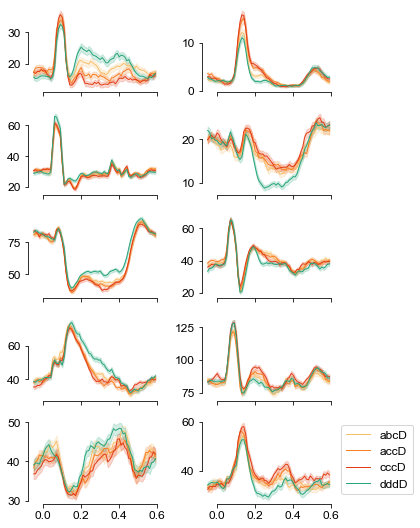

In [218]:
## alpha = .01
sig_ind = np.where(stats.Dev_vs_Alt[0]<alpha)[0]
coef = np.mean(np.mean(Coef[:,:,sig_ind[:13]],0),-1)
ind = np.argsort(coef)
MUA_last = MUAall[itemID==3,:]
labels = ['abcD','accD','cccD','dddD']
colors = ['#f7be6b','#f77e23','#e23d17','#28a57c']
linestyles = ['-','-','-','-']
N = 5
fig,ax = plt.subplots(N,2,figsize=(6,N*1.5),sharex=True)

# plot lowest two
for i in range(N):
    ch = ind[i]

    # plot overall overarge
    for c in range(4):
        m = np.mean(MUA_last[trial_type==c,ch,:],0)
        sem = np.std(MUA_last[trial_type==c,ch,:],0)/np.sqrt(sum(trial_type==c))
        ax[i,0].plot(time_bins+binsize,m,label=labels[c],linewidth=1,color=colors[c],linestyle=linestyles[c])
        ax[i,0].fill_between(time_bins[:]+binsize,m-sem,m+sem,alpha=.2,color=colors[c])
print('Largest:')        
for i in range(N):
    ch = ind[-i-1]

    # plot overall overarge
    for c in range(4):
        m = np.mean(MUA_last[trial_type==c,ch,:],0)
        sem = np.std(MUA_last[trial_type==c,ch,:],0)/np.sqrt(sum(trial_type==c))
        ax[i,1].plot(time_bins+binsize,m,label=labels[c],linewidth=1,color=colors[c],linestyle=linestyles[c])
        ax[i,1].fill_between(time_bins[:]+binsize,m-sem,m+sem,alpha=.2,color=colors[c])
plt.legend(bbox_to_anchor=(1,1))
plt.xticks(np.arange(0,.7,.2))
plt.tight_layout()
sb.despine(trim=True)
plt.savefig(os.path.join('plots','RvsA_MUA_examples.pdf'),bbox_inches='tight')
plt.show()


## Single-image examples

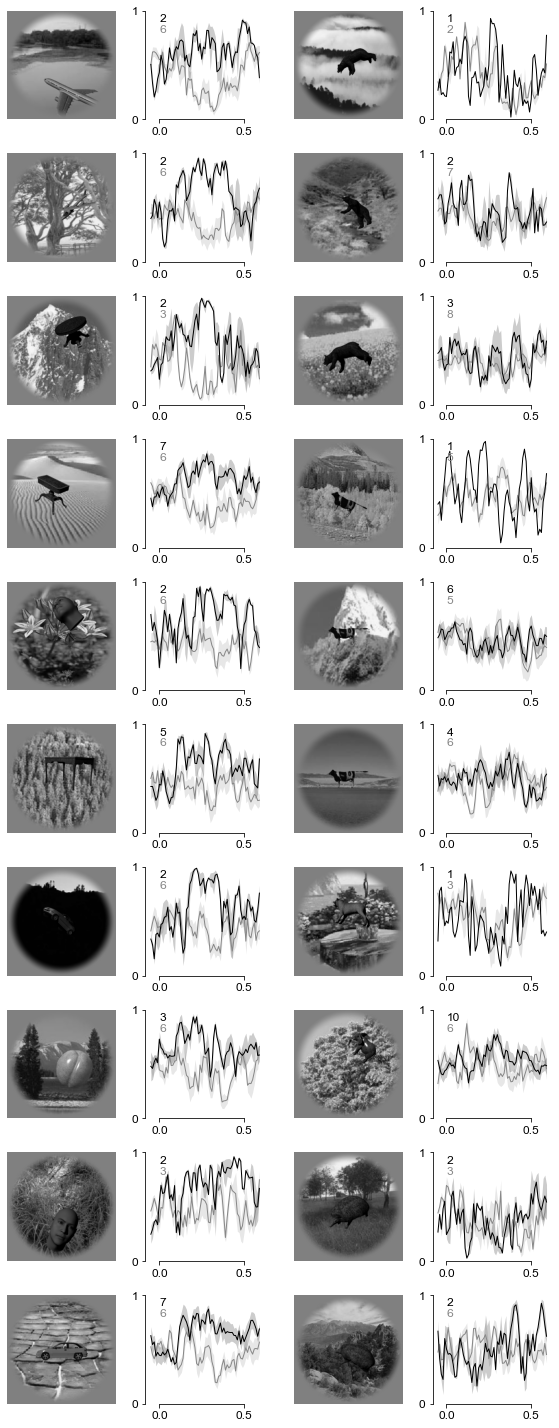

In [327]:
# plot population response for single images
import imageio

local_storage = '/Users/mebellet/Documents/PhD/stimuli'

im_ind = np.where(rep_count*alt_count>0)[0]
sig_ind = np.where(stats.Deviant[0]<alpha)[0]
N = 8
# for each image, get average differrence between repeat and deviant
effect_size = np.zeros(len(im_ind))
for j in range(len(im_ind)):
    #np.random.permutation(len(im_ind))[0]
    imID = im_ind[j]

    try:
        prob0 = np.mean(Prob[(alt==0) & (stim_ID==imID) & (itemID!=0),:][:,sig_ind],0)
        prob1 = np.mean(Prob[(alt==1) & (stim_ID==imID) & (itemID!=0),:][:,sig_ind],0)
        effect_size[j] = np.mean(prob1-prob0)
    except:
        continue
null_effect = np.where((effect_size>0) & (effect_size<.05))[0]
effect_ordered = np.argsort(effect_size)        
N = 10
fig,ax = plt.subplots(N,4,figsize=(8,2*N),sharey=False)
colors = ['#888888','#000000']
for n in range(N):
    # preferred
    imID = im_ind[effect_ordered[-n-1]]
    for i in range(2): # rep or alt
        trials = np.where((alt==i) & (stim_ID==imID) & (itemID!=0))[0]
        av = np.mean(Prob[trials,:],0)
        sem = np.std(Prob[trials,:],0) / np.sqrt(len(trials))
        
        ax[n,1].plot(time_bins+binsize,av,linewidth=1,color=colors[i])
        ax[n,1].fill_between(time_bins+binsize,av-sem,av+sem,alpha=.2,linewidth=0,color=colors[i])
        ax[n,1].annotate(str(len(trials)),xy=(0,.8+.1*i),color=colors[i])
    ax[n,1].set_ylim(0,1)
    ax[n,1].set_yticks([0,1])
    name = unique_IDs[imID]
    ii = name.find('DiCarlo')+8
    fname = os.path.join(local_storage,name[ii:])
    # load image
    try:
        im = imageio.imread(fname)
        ax[n,0].imshow(im)
    #ax[n,0].set_title(unique_IDs[imID])
    except:
        print('image not found')
    ax[n,0].axis('off')    
    # no effect
    imID = im_ind[null_effect[n]]
    for i in range(2): # rep or alt
        trials = np.where((alt==i) & (stim_ID==imID) & (itemID!=0))[0]
        av = np.mean(Prob[trials,:],0)
        sem = np.std(Prob[trials,:],0) / np.sqrt(len(trials))
        
        ax[n,3].plot(time_bins+binsize,av,linewidth=1,color=colors[i])
        ax[n,3].fill_between(time_bins+binsize,av-sem,av+sem,alpha=.2,linewidth=0,color=colors[i])
        ax[n,3].annotate(str(len(trials)),xy=(0,.8+.1*i),color=colors[i])
    ax[n,3].set_ylim(0,1)
    ax[n,3].set_yticks([0,1])
    name = unique_IDs[imID]
    ii = name.find('DiCarlo')+8
    fname = os.path.join(local_storage,name[ii:])
    # load image
    try:
        im = imageio.imread(fname)
        ax[n,2].imshow(im)
    #ax[n,0].set_title(unique_IDs[imID])
    except:
        print('image not found')
    ax[n,2].axis('off')    
#plt.plot(time_bins+binsize,np.ones(nbins)*.5,'k',linewidth=1,linestyle='--')
sb.despine(trim=True)
plt.tight_layout()
plt.savefig(os.path.join('plots','RvsA_Image_examples.pdf'),bbox_inches='tight')
plt.show()

# Model for adaptation / change (aa vs. bA in second or third position)
[aBcd, abCd] vs. [bBbc, bcCd]


In [7]:
from sklearn.linear_model import LogisticRegression
soa = 0.6

trials = (((itemID[1:]==1)) | ((itemID[1:]==2) & (alt[:-1]==1))) & (np.round(stim_soa[1:],1)==soa) # select trials for training
trials = np.concatenate((np.zeros(1).astype(bool),trials))
alt1 = alt[trials]

unique_in_training_item = np.unique(stim_ID[trials]) # get unique stim IDs in selected sequence position
n_unique = len(unique_in_training_item)
print('Number of unique stim in position %s with SOA=%s: %s'%(which_item+1,soa,n_unique))
K = n_unique # leave-one-stim-out CV

nbins = len(time_bins)

# get stimulus identities that don't occur in selected position:
not_included = np.zeros(n_stim)
for s in range(n_stim):
    stim = stim_ID[s]
    if int(stim) not in unique_in_training_item:
        not_included[s] = 1
not_included = not_included.astype(int)

Prob_alt = np.zeros((n_stim,nbins))
Coef_alt = np.zeros((K,nch,nbins))

for k,stim in enumerate(unique_in_training_item):
    print('Stimulus %s/%s'%(k+1,n_unique))
    training_ind = np.where(stim_ID[trials]!=stim)[0]
    test_ind = stim_ID==stim
    
    # balance training data    
    n = np.min([sum(alt1[training_ind]==0),sum(alt1[training_ind]==1)])
    ind = []
    for t in range(2):
        cond_ind = np.where(alt1[training_ind]==t)[0]
        ind.extend(cond_ind[np.random.permutation(len(cond_ind))][:n])
    training_ind = training_ind[ind]
    MUA_train = MUAc[trials,:][training_ind,:]
    y_train = alt1[training_ind]

    print('N training trials:',len(y_train))
    print('Ratio of aB/bb trials in training data:',np.mean(y_train))
    for b in range(nbins):
        model = LogisticRegression(fit_intercept=True,solver='lbfgs').fit(MUA_train[:,:,b],y_train)
        # get predictive probability for test stimulus, all positions
        Prob_alt[test_ind,b] = model.predict_proba(MUAc[test_ind,:][:,:,b])[:,1]
        Coef_alt[k,:,b] = model.coef_
        if k==0: # only once for stim that are never in training data:
            Prob_alt[not_included==1,b] = model.predict_proba(MUAc[not_included==1,:][:,:,b])[:,1]

Number of unique stim in position 3 with SOA=0.6: 567
Stimulus 1/567
N training trials: 2732
Ratio of aB/bb trials in training data: 0.5
Stimulus 2/567
N training trials: 2726
Ratio of aB/bb trials in training data: 0.5
Stimulus 3/567
N training trials: 2726
Ratio of aB/bb trials in training data: 0.5
Stimulus 4/567
N training trials: 2724
Ratio of aB/bb trials in training data: 0.5
Stimulus 5/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 6/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 7/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 8/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 9/567
N training trials: 2730
Ratio of aB/bb trials in training data: 0.5
Stimulus 10/567
N training trials: 2718
Ratio of aB/bb trials in training data: 0.5
Stimulus 11/567
N training trials: 2730
Ratio of aB/bb trials in training data: 0.5
Stimulus 12/567
N training tria

Stimulus 98/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 99/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 100/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 101/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 102/567
N training trials: 2722
Ratio of aB/bb trials in training data: 0.5
Stimulus 103/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 104/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 105/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 106/567
N training trials: 2726
Ratio of aB/bb trials in training data: 0.5
Stimulus 107/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 108/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 109/567
N training trials: 2728
Ratio of aB/bb trials in t

Stimulus 195/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 196/567
N training trials: 2724
Ratio of aB/bb trials in training data: 0.5
Stimulus 197/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 198/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 199/567
N training trials: 2730
Ratio of aB/bb trials in training data: 0.5
Stimulus 200/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 201/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 202/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 203/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 204/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 205/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 206/567
N training trials: 2730
Ratio of aB/bb trials in

Stimulus 292/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 293/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 294/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 295/567
N training trials: 2732
Ratio of aB/bb trials in training data: 0.5
Stimulus 296/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 297/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 298/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 299/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 300/567
N training trials: 2732
Ratio of aB/bb trials in training data: 0.5
Stimulus 301/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 302/567
N training trials: 2726
Ratio of aB/bb trials in training data: 0.5
Stimulus 303/567
N training trials: 2732
Ratio of aB/bb trials in

Stimulus 389/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 390/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 391/567
N training trials: 2730
Ratio of aB/bb trials in training data: 0.5
Stimulus 392/567
N training trials: 2732
Ratio of aB/bb trials in training data: 0.5
Stimulus 393/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 394/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 395/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 396/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 397/567
N training trials: 2720
Ratio of aB/bb trials in training data: 0.5
Stimulus 398/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 399/567
N training trials: 2732
Ratio of aB/bb trials in training data: 0.5
Stimulus 400/567
N training trials: 2734
Ratio of aB/bb trials in

Stimulus 486/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 487/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 488/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 489/567
N training trials: 2734
Ratio of aB/bb trials in training data: 0.5
Stimulus 490/567
N training trials: 2730
Ratio of aB/bb trials in training data: 0.5
Stimulus 491/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 492/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 493/567
N training trials: 2732
Ratio of aB/bb trials in training data: 0.5
Stimulus 494/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 495/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 496/567
N training trials: 2728
Ratio of aB/bb trials in training data: 0.5
Stimulus 497/567
N training trials: 2730
Ratio of aB/bb trials in

In [19]:
np.save(os.path.join(out_path,'RvsA_Probalt.npy'),Prob_alt)
np.save(os.path.join(out_path,'RvsA_Coefalt.npy'),Coef_alt)

AUC

In [18]:
# AUC
nperm = 100
# trial types to be tested: 0 or 2 against 3
test_trial_types = [0,2]
AUCalt = np.zeros((3,nbins))
RandAUCalt = np.zeros((3,nbins,nperm))
#
# ABCD and cccD trials
for tt,tr in enumerate(test_trial_types):
    ind = np.where(((trial_type==tr) | (trial_type==3)) & (np.round(stim_soa[itemID==3],2)==.6))[0]
    y = alt[itemID==3][ind]
    x = Prob_alt[itemID==3,:][ind,:]
    for b in range(nbins):
        AUCalt[tt,b] = roc_auc_score(y,x[:,b])
    # permutations
    for perm in range(nperm):
        randind = np.random.permutation(len(ind))
        for b in range(nbins):
            RandAUCalt[tt,b,perm] = roc_auc_score(y[randind],x[:,b])
        
# position 2 or 3 aa vs aB or abb vs. abc
trials = (((itemID[1:]==1)) | ((itemID[1:]==2) & (alt[:-1]==1))) & (np.round(stim_soa[1:],1)==soa) # select trials for training
trials = np.where(np.concatenate((np.zeros(1).astype(bool),trials))==1)[0]
y = alt[trials]
x = Prob_alt[trials,:]
for b in range(nbins):
    AUCalt[-1,b] = roc_auc_score(y,x[:,b])
    # permutations
    for perm in range(nperm):
        randind = np.random.permutation(len(trials))
        for b in range(nbins):
            RandAUCalt[-1,b,perm] = roc_auc_score(y[randind],x[:,b])


# AUC for deviance vs alternation along this axis
AUCalt_dev_vs_alt = np.zeros(nbins)
RandAUCalt_dev_vs_alt = np.zeros((nbins,nperm))
trials = np.where(((trial_type==0) | (trial_type==2)) & (np.round(stim_soa[itemID==3],2)==.6))[0]
y = trial_type[trials]; y[y>0] = 1
x = Prob_alt[itemID==3,:][trials,:]
for b in range(nbins):
    AUCalt_dev_vs_alt[b] = roc_auc_score(y,x[:,b])
#    # permutations
    for perm in range(nperm):
        randind = np.random.permutation(len(trials))
        for b in range(nbins):
            RandAUCalt_dev_vs_alt[b,perm] = roc_auc_score(y[randind],x[:,b])

np.save(os.path.join(out_path,'RvsA_AUCalt.npy'),AUCalt)
np.save(os.path.join(out_path,'RvsA_RandAUCalt.npy'),RandAUCalt)
np.save(os.path.join(out_path,'RvsA_AUCalt_dev_vs_alt.npy'),AUCalt_dev_vs_alt)
np.save(os.path.join(out_path,'RvsA_RandAUCalt_dev_vs_alt.npy'),RandAUCalt_dev_vs_alt)

0.0
0.0
0.0


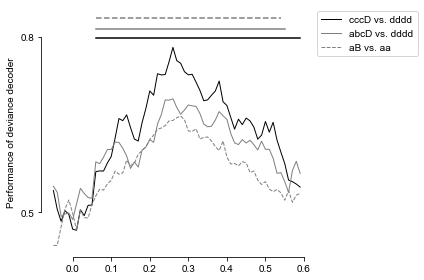

0.0


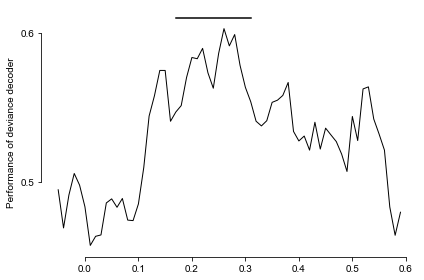

In [21]:
# clustertest
threshold = 3
alpha = 0.01

labels = ['abcD vs. dddd','cccD vs. dddd','aB vs. aa']
names = ['Deviant','Alternation_last','Alternation_second','Dev_vs_Alt']
stats = pd.DataFrame(columns=names) # store stats here

# plot
plt.figure()

#plt.ylim(.45,None)
#plt.xticks(np.arange())
plt.yticks((.5,.8))
plt.ylabel('Performance of deviance decoder')

# clustertest
cols = ['k',[.5,.5,.5],[.5,.5,.5]]
linestyles = ['-','-','--']
for ii,tt in enumerate([1,0,2]):
    plt.plot(time_bins+binsize,AUCalt[tt,:],color=cols[ii],linewidth=1,label=labels[tt],linestyle=linestyles[ii])
    
    p = clustertest(AUCalt[tt,:],RandAUCalt[tt,:],threshold)

    l = label(~np.isnan(p))
    ymin,ymax = plt.ylim()
    for j in np.unique(l):
        if p[l==j][0]<=alpha:
            print(p[l==j][0])
            plt.plot(time_bins[l==j]+binsize,np.ones(sum(l==j))*ymax,color=cols[ii],
                     linestyle=linestyles[ii],linewidth=1.5)
   
    stats[names[ii]] = [p]
    
plt.legend(bbox_to_anchor=(1,1))
plt.yticks((.5,.8))
sb.despine(trim=True)
plt.tight_layout()
plt.savefig(os.path.join(out_path,'RvsA_Alt_AUC.pdf'),bbox_inches='tight')
plt.show()


# -------- PLOT DEV vs. ALT last position

plt.figure()

#plt.ylim(.45,.8)
#plt.xticks(np.arange())
plt.yticks((.5,.6))
plt.ylabel('Performance of deviance decoder')

# clustertest
plt.plot(time_bins+binsize,AUCalt_dev_vs_alt,color='k',linewidth=1)

p = clustertest(AUCalt_dev_vs_alt,RandAUCalt_dev_vs_alt,threshold)

l = label(~np.isnan(p))
ymin,ymax = plt.ylim()
for j in np.unique(l):
    if p[l==j][0]<=alpha:
        print(p[l==j][0])
        plt.plot(time_bins[l==j]+binsize,np.ones(sum(l==j))*ymax,color='k',
                 linewidth=1.5)

stats[names[-1]] = [p]
sb.despine(trim=True)
plt.tight_layout()
plt.savefig(os.path.join('plots','RvsA_Alt_Dev_vs_Alt_AUC.pdf'),bbox_inches='tight')
plt.show()